<a href="https://colab.research.google.com/github/robrosk/FrozenLakeReinforcementLearning/blob/main/RLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frozen Lake RL



In [2]:
pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=91aed23132662a54243e462ed15d1842281c3ca16b6900a76dadec9f6bd12c63
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

import time
from collections import deque, namedtuple
import numpy as np
import PIL.Image
import tensorflow as tf
import utils
import random

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [13]:
# Hyperparameters
MEMORY_SIZE = 100000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
MINI_BATCH_SIZE = 8

In [14]:
# Define the grid (4x4)
grid = [
    ['S', 'F', 'F', 'F'],
    ['F', 'H', 'F', 'H'],
    ['F', 'F', 'F', 'H'],
    ['H', 'F', 'F', 'G']
]

# Convert to numerical states for easier handling:
state_grid = np.array([
    [0, 1, 1, 1],
    [1, 2, 1, 2],
    [1, 1, 1, 2],
    [2, 1, 1, 3]
])

In [15]:
class CustomFrozenLake:
    def __init__(self):
        self.grid = state_grid
        self.n_rows, self.n_cols = self.grid.shape
        self.state = (0, 0)  # Start position (row, column)
        self.done = False

        # Actions: 0=left, 1=right, 2=up, 3=down
        self.action_space = [0, 1, 2, 3]

    def reset(self):
        self.state = (0, 0)
        self.done = False
        return self.state

    def step(self, action):
        row, col = self.state

        # Apply action (with 20% chance of slipping to a random direction)
        original_action = action
        if np.random.rand() < 0.20:  # Stochastic environment
            action = np.random.choice(self.action_space)

        # Calculate new position
        if action == 0: new_state = (row, max(col-1, 0))          # Left
        elif action == 1: new_state = (row, min(col+1, self.n_cols-1))  # Right
        elif action == 2: new_state = (max(row-1, 0), col)        # Up
        elif action == 3: new_state = (min(row+1, self.n_rows-1), col)  # Down

        # Get cell type
        cell_value = self.grid[new_state]

        # Determine reward and termination
        if cell_value == 3:  # Goal
            reward = 10
            done = True
        elif cell_value == 2:  # Hole
            reward = -5
            done = True
        else:  # Frozen
            reward = 0
            done = False

        self.done = done
        self.state = new_state
        return action, new_state, reward, done

In [16]:
def pos_to_one_hot(row, col):
    """Convert (row, col) into a one-hot vector of length 16."""
    state_idx = row * 4 + col  # integer in [0..15]
    one_hot = np.zeros(16, dtype=np.float32)
    one_hot[state_idx] = 1.0
    return one_hot

In [17]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
n_actions = 4
n_states = state_grid.size

In [18]:
# Q-Network
q_network = Sequential([
    tf.keras.layers.Input(shape=(state_grid.size,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_actions, activation='linear')
])

# Target Q-Network
target_q_network = Sequential([
    tf.keras.layers.Input(shape=(state_grid.size,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_actions, activation='linear')
])

optimizer = Adam(learning_rate=ALPHA)

In [19]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates and returns the loss for the Q-learning update.

    Args:
        experiences (tuple): Tuple of (state, action, reward, next_state, done)
        gamma (float): Discount factor
        q_network: (tf.keras.Sequential) Keras model for predicting the q_values
        target_q_network: (tf.keras.Sequential) Keras model for predicting the targets

    Returns:
        loss: (TensorFLow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between the y targets and the Q(s,a) values
    """
    states, actions, rewards, next_states, done_vals = experiences

    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # get Q-values for the current state
    q_values = q_network(states)

    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))

    loss = MSE(y_targets, q_values)

    return loss


In [22]:
def get_action(q_values, epsilon):
    """
    Given Q-values for one state (shape (1, num_actions)) and epsilon,
    choose an action with epsilon-greedy policy.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(q_values.shape[1])
    else:
        return np.argmax(q_values[0])


def check_update_conditions(time_step, num_steps_for_update, memory_buffer):
    if (time_step + 1) % num_steps_for_update == 0 and len(memory_buffer) >= MINI_BATCH_SIZE:
        return True
    else:
        return False


def get_new_epsilon(epsilon, epsilon_decay=0.98):
    return max(0.05, epsilon_decay * epsilon)

def get_experiences(memory_buffer, batch_size=MINI_BATCH_SIZE):
    # 1) Randomly sample from the replay buffer
    experiences = random.sample(memory_buffer, k=batch_size)

    # 2) Separate each field into its own array
    states      = np.array([e.state for e in experiences],      dtype=np.float32)
    actions     = np.array([e.action for e in experiences],     dtype=np.int32)
    rewards     = np.array([e.reward for e in experiences],     dtype=np.float32)
    next_states = np.array([e.next_state for e in experiences], dtype=np.float32)
    dones       = np.array([e.done for e in experiences],       dtype=np.float32)

    return (states, actions, rewards, next_states, dones)

In [23]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q network

    Args:
        experiences (tuple): Tuple of (state, action, reward, next_state, done)
        gamma (float): Discount factor
    """

    # Compute Loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))


def update_target_network(q_network, target_q_network):
    """
    Hard update: copy the weights from the q_network to the target_q_network
    """
    target_q_network.set_weights(q_network.get_weights())

In [24]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 50

total_point_history = []

num_p_av = 100 # number of total point to use for averaging
epsilon = 1.0 # initial epsilon value for epsilon-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weigths equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

# Create environment
env = CustomFrozenLake()

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for t in range(max_num_timesteps):
        state_qn = np.expand_dims(pos_to_one_hot(*state), axis=0)
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        # Take action
        action, next_state, reward, done = env.step(action)

        memory_buffer.append(experience(pos_to_one_hot(*state), action, reward, pos_to_one_hot(*next_state), done))

        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            experiences = get_experiences(memory_buffer)
            agent_learn(experiences, GAMMA)

        state = next_state
        total_reward += reward

        if done:
            break

    if (episode + 1) % 100 == 0:
        update_target_network(q_network, target_q_network)

    total_point_history.append(total_reward)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # update epsilon
    epsilon = get_new_epsilon(epsilon)

    if (episode + 1) % num_p_av == 0:
        print(f"\rEpisode {episode+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    if av_latest_points > 7:
        print(f"\n\nEnvironment solved in {episode+1} episodes!")
        q_network.save("FrozenLake.h5")
        break

tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -4.85
Episode 200 | Total point average of the last 100 episodes: -4.65
Episode 300 | Total point average of the last 100 episodes: -3.25
Episode 400 | Total point average of the last 100 episodes: -3.25
Episode 500 | Total point average of the last 100 episodes: 2.75
Episode 600 | Total point average of the last 100 episodes: 1.55
Episode 700 | Total point average of the last 100 episodes: 5.25
Episode 800 | Total point average of the last 100 episodes: 4.95
Episode 900 | Total point average of the last 100 episodes: 1.80
Episode 1000 | Total point average of the last 100 episodes: -0.50
Episode 1100 | Total point average of the last 100 episodes: -1.65
Episode 1200 | Total point average of the last 100 episodes: -2.05
Episode 1300 | Total point average of the last 100 episodes: 3.90
Episode 1400 | Total point average of the last 100 episodes: 0.55
Episode 1500 | Total point average of the last 100 episodes: 3.55
Episode 1600

In [25]:
def render(state):
    grid_display = np.array(grid, dtype='object')
    grid_display[state] = 'A'  # 'A' marks the agent's position
    print("Current Grid:")
    print(np.array2string(grid_display, formatter={'all': lambda x: str(x)}))

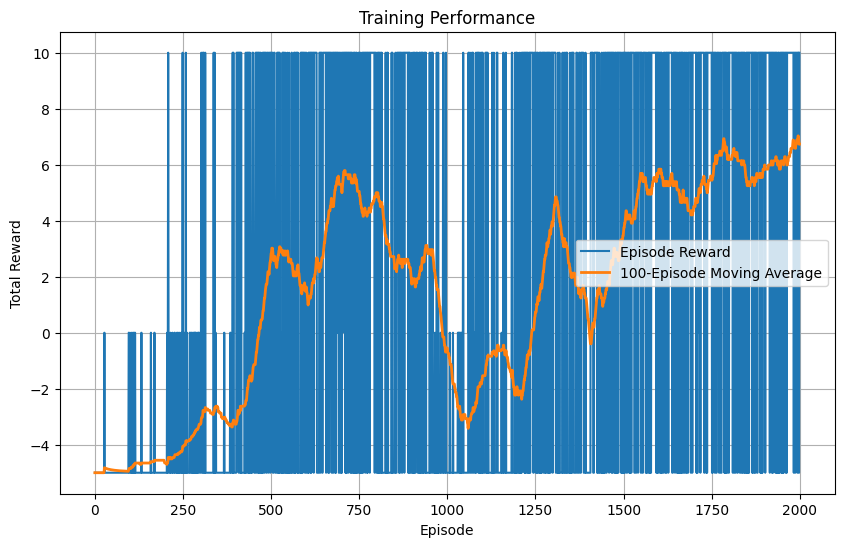

In [26]:
def plot_training_rewards(rewards, avg_window=100):
    """
    Plot training rewards and the moving average.

    Args:
        rewards: List of rewards per episode.
        avg_window: Window size for the moving average.
    """
    # Compute moving average
    moving_avg = [np.mean(rewards[max(0, i-avg_window):i+1]) for i in range(len(rewards))]

    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label="Episode Reward")
    plt.plot(moving_avg, label=f"{avg_window}-Episode Moving Average", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the rewards
plot_training_rewards(total_point_history, avg_window=100)

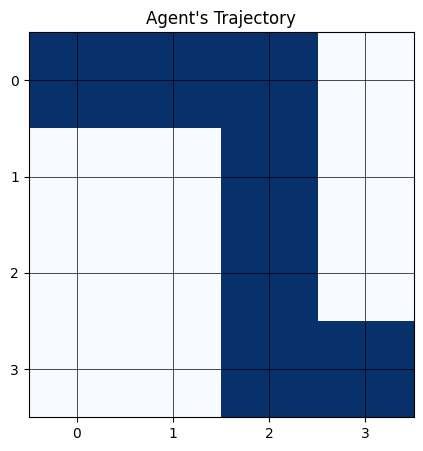

Goal reached!


In [27]:
def visualize_episode(env, q_network):
    """
    Run a single episode and visualize the agent's trajectory.

    Args:
        env: The environment to step through.
        q_network: The trained Q-network.
    """
    state = env.reset()
    trajectory = [state]

    while True:
        state_qn = np.expand_dims(pos_to_one_hot(*state), axis=0)
        q_values = q_network(state_qn)
        action = np.argmax(q_values[0].numpy())

        # Take action
        action, next_state, reward, done = env.step(action)

        trajectory.append(next_state)
        if done:
            break

        state = next_state

    # Visualize the trajectory
    grid = np.zeros((4, 4))
    for row, col in trajectory:
        grid[row, col] = 1  # Mark trajectory cells

    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap="Blues", origin="upper")
    plt.title("Agent's Trajectory")
    plt.xticks(range(4))
    plt.yticks(range(4))
    plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
    plt.show()

    return reward

# Visualize a single episode
reward = visualize_episode(env, q_network)
if reward == 10:
    print("Goal reached!")
else:
    print("Goal not reached.")

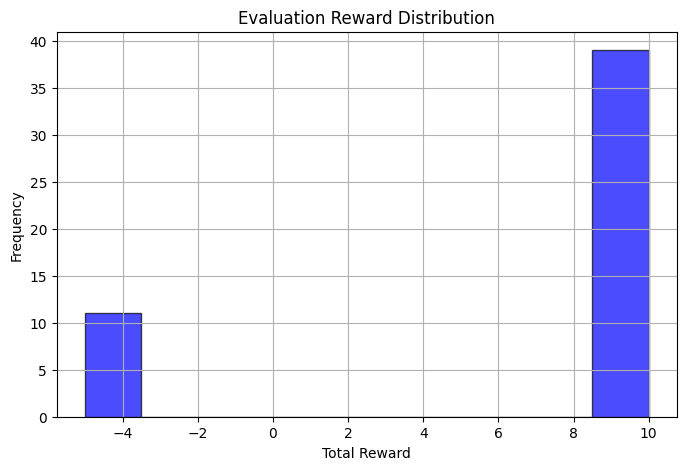

In [28]:
def sample_model(env, q_network, num_episodes=10):
    """
    Evaluate the trained policy by sampling from the model

    Args:
        env: The environment to step through.
        q_network: The trained Q-network.
        num_episodes: Number of episodes to sample.

    Returns:
        rewards: A list of total rewards obtained per episode
    """
    rewards = []
    trajectories = [] # To track state-action sequences for analysis

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        trajectory = []

        while True:
            state_qn = np.expand_dims(pos_to_one_hot(*state), axis=0)
            q_values = q_network(state_qn)
            # action = get_action(q_values, epsilon) # no longer using since not training
            action = np.argmax(q_values[0].numpy())

            # Take action
            action, next_state, reward, done = env.step(action)

            trajectory.append((state, action))

            total_reward += reward

            if done:
                break

            state = next_state

        rewards.append(total_reward)
        trajectories.append(trajectory)

    return rewards, trajectories

evaluation_rewards, trajectories = sample_model(env, q_network, num_episodes=50)

plt.figure(figsize=(8, 5))
plt.hist(evaluation_rewards, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Evaluation Reward Distribution')
plt.grid(True)
plt.show()